In [7]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from helpers import train, evaluation, generate_confusion_matrix
from helpers import plot_accuracy, plot_loss, plot_confusion_matrix

In [8]:
DATA_PATH = './15SceneData/'
MODELS_PATH = './models/'
PLOTS_PATH = './plots/'
MODEL_NAME = 'efficientnetb0_v2'

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

NUM_CLASSES = 15
BATCH_SIZE = 32
NUM_EPOCHS = 100
PATIENCE = 30

# Load Data

In [9]:
# Load the dataset
# Here I added some data augmentation - random resized crop
# I used the mean and std calculated from imagenet dataset as while using pretrained models thats the values that should be used
train_dataset = datasets.ImageFolder(DATA_PATH + 'train',
                                     transform=transforms.Compose([
                                         transforms.Resize((224, 224)),
                                         transforms.RandomResizedCrop(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
                                     ]))

val_dataset = datasets.ImageFolder(DATA_PATH + 'validation',
                                   transform=transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
                                   ]))

# Create data loaders

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Load pretrained model

In [11]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Change the classifier part of model to fit our problem
print('BEFORE:', model.classifier)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, NUM_CLASSES)
)
print('AFTER:', model.classifier)

BEFORE: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
AFTER: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=15, bias=True)
)


In [12]:
# Train the model
# For the purpose of regularization I used weight decay in the optimizer as well as lr_scheduler
# Lr_scheduler reduces the learning rate when the validation loss plateaus
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

model.to(DEVICE)

fitted, train_loss, train_acc, val_loss, val_acc = train(
    model, 
    optimizer,
    loss_fn,
    train_loader, 
    val_loader, 
    lr_scheduler=lr_scheduler,
    num_epochs=NUM_EPOCHS, 
    patience=PATIENCE, 
    device=DEVICE
    )

torch.save(fitted, MODELS_PATH + MODEL_NAME + '.pt')

Epoch [23/100]: 100%|██████████| 47/47 [00:17<00:00,  2.66it/s, train_acc=91.4, train_loss=0.265, val_acc=88.8, val_loss=0.368]


Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.


Epoch [42/100]: 100%|██████████| 47/47 [00:17<00:00,  2.65it/s, train_acc=95.2, train_loss=0.147, val_acc=90.2, val_loss=0.31] 


Epoch 00042: reducing learning rate of group 0 to 1.0000e-05.


Epoch [54/100]: 100%|██████████| 47/47 [00:17<00:00,  2.65it/s, train_acc=96.5, train_loss=0.116, val_acc=90.5, val_loss=0.293]


Epoch 00054: reducing learning rate of group 0 to 1.0000e-06.


Epoch [71/100]: 100%|██████████| 47/47 [00:17<00:00,  2.65it/s, train_acc=95.9, train_loss=0.122, val_acc=90.7, val_loss=0.29]


Epoch 00071: reducing learning rate of group 0 to 1.0000e-07.


Epoch [82/100]: 100%|██████████| 47/47 [00:17<00:00,  2.68it/s, train_acc=96.1, train_loss=0.127, val_acc=90.6, val_loss=0.295]


Epoch 00082: reducing learning rate of group 0 to 1.0000e-08.


Epoch [90/100]: 100%|██████████| 47/47 [00:17<00:00,  2.62it/s, train_acc=95.3, train_loss=0.138, val_acc=90.5, val_loss=0.3] 


Early stopping!


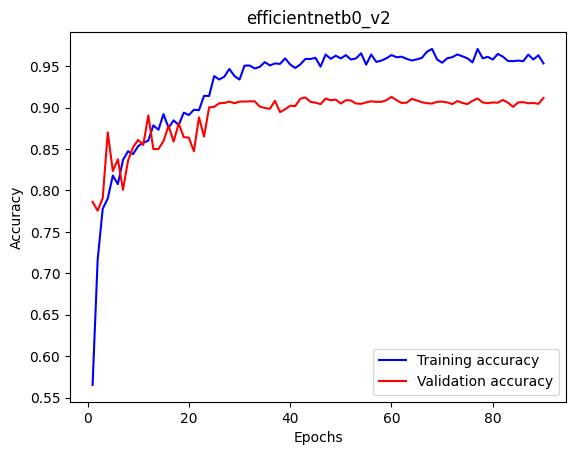

In [17]:
plot_accuracy(train_acc, val_acc, MODEL_NAME, PLOTS_PATH + MODEL_NAME + '_accuracy.png')

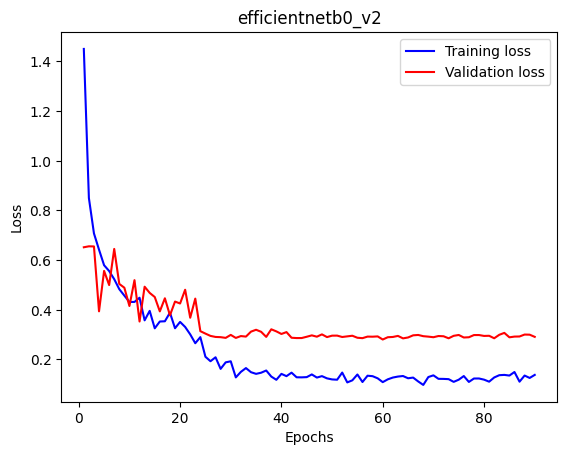

In [18]:
plot_loss(train_loss, val_loss, MODEL_NAME, PLOTS_PATH + MODEL_NAME + '_loss.png')

In [19]:
_, train_accuracy = evaluation(fitted, train_loader, nn.CrossEntropyLoss(), DEVICE)
_, val_accuracy = evaluation(fitted, val_loader, nn.CrossEntropyLoss(), DEVICE)

print(f'Train accuracy: {train_accuracy*100.:.2f}%')
print(f'Validation accuracy: {val_accuracy*100.:.2f}%')

Train accuracy: 97.60%
Validation accuracy: 91.29%


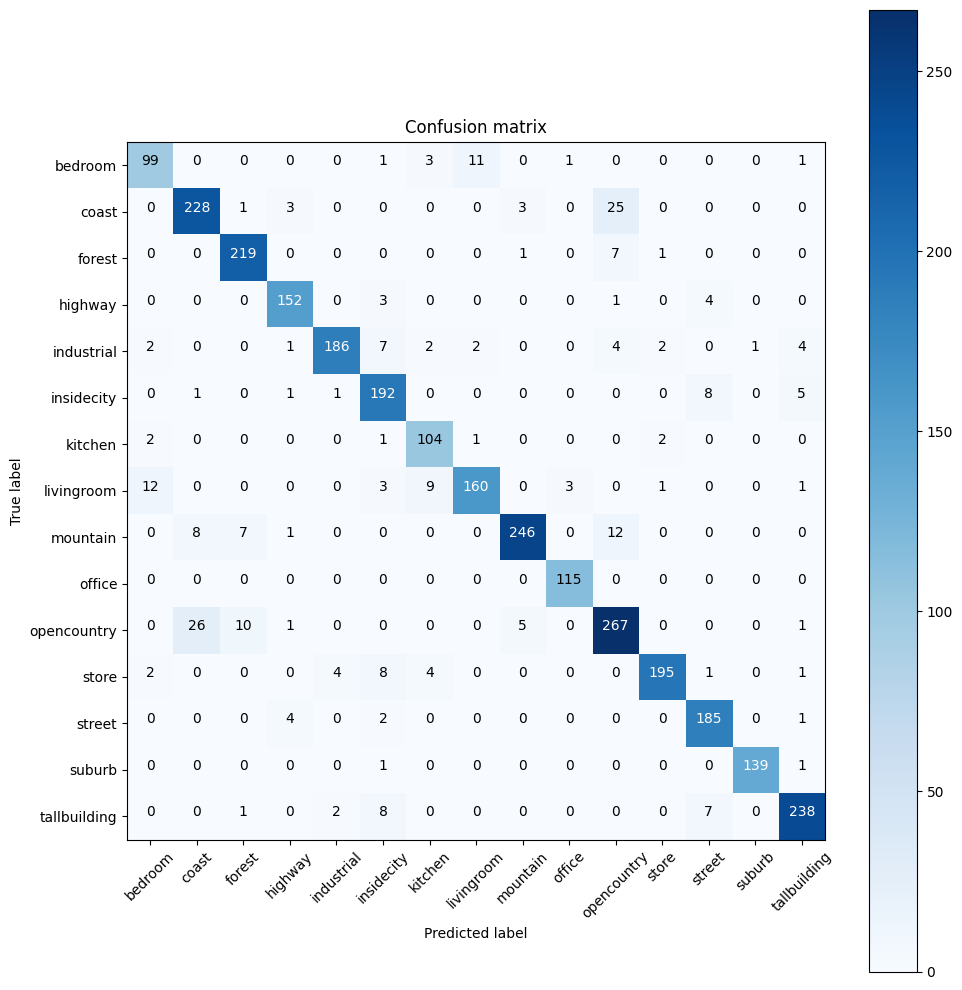

In [20]:
cm = generate_confusion_matrix(fitted, val_loader, DEVICE)

plot_confusion_matrix(
    cm,
    val_loader.dataset.classes,
    'Confusion matrix',
    PLOTS_PATH + MODEL_NAME + '_confusion_matrix.png',
    normalize=False
)